In [2]:
import pandas as pd
import json
import os

## 경고 무시
import warnings
warnings.filterwarnings('ignore')

## 시각화 툴
import matplotlib.pyplot as plt
import seaborn as sns

## 정규식 
import re

## 형태소 분석기
from konlpy.tag import Okt

## 띄어쓰기 교정
from konlpy.tag import Hannanum

## encoding 
from sklearn.preprocessing import LabelEncoder

## vocabulary
import tensorflow_datasets as tfds

## Data Load

In [10]:
train_df = pd.read_csv("../data/train.csv")
# train_general_text = pd.read_csv("train_ge.csv")
# train_general = train_general_text.loc[3950:, ["idx", "conversation"]]
# train_general["class"] = "일반 대화"

with open ("../data/test.json", "r") as f:
    test_df = json.load(f)

test = pd.DataFrame(test_df).T.reset_index().rename(columns={"index":"file_name"})

In [5]:
# train = pd.concat([train_df, train_general])

NameError: name 'train_general' is not defined

## Exploratory Data Analysis

In [6]:
## train class
train["class"].value_counts()

NameError: name 'train' is not defined

In [7]:
## conversation 길이에 대한 통계치
train["conversation"].apply(lambda x: len(x.split())).describe()

NameError: name 'train' is not defined

In [8]:
test["text"].apply(lambda x: len(x.split())).describe()

count    500.000000
mean      54.102000
std       26.137136
min       14.000000
25%       37.000000
50%       48.000000
75%       65.000000
max      192.000000
Name: text, dtype: float64

NameError: name 'train' is not defined

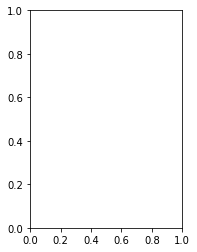

In [9]:
plt.subplot(1,2,1)
sns.boxplot(train["conversation"].apply(lambda x: len(x.split())))
plt.title("train")
plt.subplot(1,2,2)
sns.boxplot(test["text"].apply(lambda x: len(x.split())))
plt.title("test")

In [11]:
train_df["conversation"][3]

'어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?\n얘 돈 좀 있나봐\n아니에요.돈 없어요\n뒤져서 나오면 넌 죽는다\n오늘 피시방 콜?\n콜. 마지막 기회다. 있는거 다 내놔\n정말 없어요'

In [12]:
test["text"][3]

'이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 요즘 듣는 것도 들어봐 음 난 좀 별론데 좋을 줄 알았는데 아쉽네 내 취향은 아닌 듯 배고프다 밥이나 먹으러 가자 그래'

## Preprocessing
#### 해결해야 할까??
---
- \n에 부분에 token을 추가해야할까?
- "죽여달라고", "죽여버리고", "죽을 거면", "죽여버려야겠군" 모두 같은 말인데 모델에 다르게 들어간다. 
- 품사 태깅을 수행해야 할까?
- 개체명을 인식해야 할까?

#### 진행한 전처리
---
1. 띄어쓰기 교정 X
2. 정규식 전처리 
3. 형태소 분석기 사용 ex) 스스로를 -> 스스로 를
4. [temp] 불용어 처리 
5. 라벨 인코딩

In [97]:
f = open("../stopword.txt", "r")
stopword_list = f.read().splitlines()

In [66]:
## 텍스트 데이터 전처리
def text_cleaner(text):
    """text 데이터를 전처리하는 함수 
    
    Args:
        text: 하나의 텍스트 데이터 샘플
    Returns:
        cleaned_text: 전처리된 하나의 텍스트 데이터 샘플
    """

    ## 2. 정규식 전처리: 한글, 영어, 숫자를 제외하고 모두 제거한다.  
    text = re.sub("[^가-힣a-zA-Z0-9]+", " ", text)
    
    ## 3. 형태소 분석기 사용
    okt = Okt()
    tokens = okt.morphs(text)

    ## 4. 한국어 불용어 처리
    tokens = [word for word in tokens if not word in stopword_list]
    cleaned_text = " ".join(tokens)    
    
    return cleaned_text

In [67]:
preprocessed_train = train_df.copy()
preprocessed_test = test_df.copy()

In [68]:
## 텍스트 데이터 전처리 40분이 넘어간다. 
preprocessed_train["conversation"] = train_df["conversation"].apply(lambda x: text_cleaner(x))
preprocessed_test["text"] = test_df["text"].apply(lambda x: text_cleaner(x))

In [ ]:
preprocessed_train.to_csv("../data/preprocessed_train_v1.csv", index=False)
preprocessed_test.to_csv("../data/preprocessed_test_v1.csv", index=False)

In [47]:
class Preprocessor:
    def __init__(
        self, 
        folder_path="../data/"
    ):
        self.folder_path = folder_path
        self.train = pd.read_csv(self.folder_path + "train.csv")
        train_general_text = pd.read_csv("train_general.csv")
        train_general = train_general_text.loc[3950:, ["idx", "conversation"]]
        train_general["class"] = "일반 대화"
        
        self.train = pd.concat([self.train, train_general])
        
        with open (self.folder_path + "/test.json", "r") as f:
            test = json.load(f)
        self.test = pd.DataFrame(test).T.reset_index().rename(columns={"index":"file_name"})
        
        f = open("../stopword.txt", "r")
        self.stopword_list = f.read().splitlines()
    

    def preprocess(
        self, 
        version:int=0
    ):
        """실제로 전처리를 진행하는 함수
        
        Args: 
            version: 버전 입력
        Returns:
            preprocessed_train: 전처리가 끝난 훈련 데이터 셋 
            preprocessed_test: 전처리가 끝난 테스트 데이터 셋 
        """
        train_file_path = "../preprocessed_data/" + f"preprocessed_train_v{version}.csv"
        test_file_path = "../preprocessed_data/" + f"preprocessed_test_v{version}.csv"
        
        ## train data
        if not os.path.exists(train_file_path):
            ## 원본 데이터 복사
            preprocessed_train = self.train.copy()

            print("train 데이터 셋을 생성합니다.")
            preprocessed_train["conversation"] = preprocessed_train["conversation"].apply(lambda x: self.text_cleaner(x))

            print("train 데이터 셋을 저장합니다.")
            preprocessed_train.to_csv(train_file_path, index=False)
        
        else:
            preprocessed_train = pd.read_csv(train_file_path)
        
        ## test data 
        if not os.path.exists(test_file_path):
            ## 원본 데이터 복사
            preprocessed_test = self.test.copy()

            print("test 데이터 셋을 생성합니다.")
            preprocessed_test["text"] = preprocessed_test["text"].apply(lambda x: self.text_cleaner(x))

            print("test 데이터 셋을 저장합니다.")
            preprocessed_test.to_csv(test_file_path, index=False)        
        
        else:
            preprocessed_test = pd.read_csv(test_file_path)
            
        
        return preprocessed_train, preprocessed_test
        
    def text_cleaner(self, text):
        """text 데이터를 전처리하는 함수 

        Args:
            text: 하나의 텍스트 데이터 샘플
        Returns:
            cleaned_text: 전처리된 하나의 텍스트 데이터 샘플
        """
        
        ## <s>, [INST], </s>, [/INST] 제거
        text = text.replace("<s>", "").replace("[INST]", "").replace("</s>", "").replace("[/INST]", "")
        
        ## 정규식 전처리: 한글, 영어, 숫자를 제외하고 모두 제거한다.  
        text = re.sub("[^가-힣a-zA-Z0-9]+", " ", text)
        
        ## 여러 개의 공백을 하나의 공백으로
        text = re.sub(r'\s+', ' ', text).strip()

        ## 형태소 분석기 사용
        okt = Okt()
        tokens = okt.morphs(text)

        ## 한국어 불용어 처리
        tokens = [word for word in tokens if not word in self.stopword_list]
        cleaned_text = " ".join(tokens)    

        return cleaned_text        

In [48]:
preprocessor = Preprocessor()

In [49]:
preprocessed_train, preprocessed_test = preprocessor.preprocess()

train 데이터 셋을 생성합니다.
train 데이터 셋을 저장합니다.
test 데이터 셋을 생성합니다.
test 데이터 셋을 저장합니다.


텍스트의 최소 길이 : 6
텍스트의 최대 길이 : 239
텍스트의 평균 길이 : 59.00422025723473


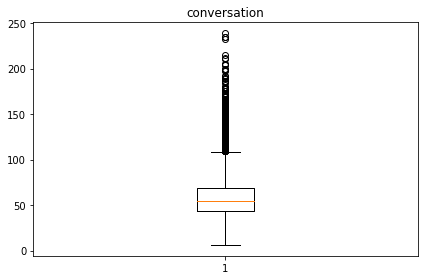

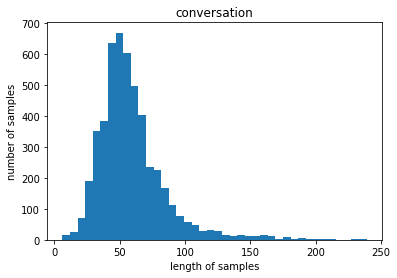

In [53]:
import numpy as np
text_len = [len(s.split()) for s in preprocessed_train['conversation']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.boxplot(text_len)
plt.title('conversation')
plt.tight_layout()
plt.show()

plt.title('conversation')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
## 텍스트 길이 설정: test 셋 길이만큼 있어야한다. 
# text_max_len = len(preprocessed_test)

## Label Encoding

In [ ]:
# CLASS_NAMES에 '일반 대화'를 포함시킴
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']

# 수동 매핑 설정
class_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

# 'class' 열을 수동 매핑 적용하기 전에 문자열로 변환
preprocessed_train['class'] = preprocessed_train['class'].astype(str).map(class_mapping)

## Tokenizer
vocab size에 따른 시각화

In [ ]:
# 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')

In [ ]:
## 토크나이져
## vocab_size 시각화 및 설정
## 전체 설계